# An Introduction to SageMaker Neural Topic Model

***Unsupervised representation learning and topic extraction using Neural Topic Model***

1. [Introduction](#Introduction)
1. [Data Preparation](#Data-Preparation)
1. [Model Training](#Model-Training)
1. [Model Hosting and Inference](#Model-Hosting-and-Inference)
1. [Model Exploration](#Model-Exploration)


---
# Introduction

Amazon SageMaker Neural Topic Model (NTM) is an unsupervised learning algorithm that attempts to describe a set of observations as a mixture of distinct categories. NTM is most commonly used to discover a user-specified number of topics shared by documents within a text corpus. Here each observation is a document, the features are the presence (or occurrence count) of each word, and the categories are the topics. Since the method is unsupervised, the topics are not specified upfront and are not guaranteed to align with how a human may naturally categorize documents. The topics are learned as a probability distribution over the words that occur in each document. Each document, in turn, is described as a mixture of topics. 

In this notebook, we will use the Amazon SageMaker NTM algorithm to train a model on the [20NewsGroups](https://archive.ics.uci.edu/ml/datasets/Twenty+Newsgroups) data set. This data set has been widely used as a topic modeling benchmark. 

The main goals of this notebook are as follows:

1. learn how to obtain and store data for use in Amazon SageMaker,
2. create an AWS SageMaker training job on a data set to produce an NTM model,
3. use the model to perform inference with an Amazon SageMaker endpoint.
4. explore trained model and visualized learned topics

If you would like to know more please check out the [SageMaker Neural Topic Model Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/ntm.html).

### A Brief Overview of SageMaker NTM

Topic models are a classical example of probablistic graphical models that involve challenging posterior inference problems. We implement topic modeling under a neural-network based variational inference framework. The difficult inference problem is framed as an optimization problem solved by scalable methods such as stochastic gradient descent. Compared to conventional inference schemes, the neural-network implementation allows for scalable model training as well as low-latency inference. Furthermore, the flexibility of the neural inference framework allows us to more quickly add new functionalities and serve a wider range of customer use cases.

The high-level diagram of SageMaker NTM is shown below:

<img src="ntm_diagram.png" width="600">

$$
\begin{equation}
\begin{split}
\textrm{Encoder} \ q(z\vert x): & \\
& \pi = f_X^{MLP}(x), \quad \mu(x) = l_1(\pi), \quad \log \sigma(x) = l_2(\pi)\\
& h(x, \epsilon) = \mu + \sigma \epsilon, \ \textrm{where} \ \epsilon \sim \mathcal{N}(0,I),\quad z=g(h), \ \textrm{where} \ h \sim \mathcal{N}(\mu, \sigma^2 I) \\
\textrm{Decoder} \ p(x\vert z): & \\
& y(z) = \textrm{softmax}(Wz+b), \quad \log p(x\vert z) = \sum x \odot \log(y(z))
\end{split}
\end{equation}
$$

where $l_1$ and $l_2$ are linear transformations with bias.

### Beyond Text Data

In principle, topic models can be applied to types of data beyond text documents. For example, topic modeling has been applied on network traffice data to discover [peer-to-peer applications usage patterns](http://isis.poly.edu/~baris/papers/GangsOfInternet-CNS13.pdf). We would be glad to hear about your novel use cases and are happy to help provide additional information. Please feel free to post questions or feedback at our [GitHub repository](https://github.com/awslabs/amazon-sagemaker-examples) or in the [Amazon SageMaker](https://forums.aws.amazon.com/forum.jspa?forumID=285) section of AWS Developer Forum.

---
# Data Preparation TODO 



## Fetching Data Set

First let's define the folder to hold the data and clean the content in it which might be from previous experiments.

In [93]:
!head -n 100 /home/ec2-user/SageMaker/chinese-corpus/toutiao_cat_data.txt

6551700932705387022_!_101_!_news_culture_!_京城最值得你来场文化之旅的博物馆_!_保利集团,马未都,中国科学技术馆,博物馆,新中国
6552368441838272771_!_101_!_news_culture_!_发酵床的垫料种类有哪些？哪种更好？_!_
6552407965343678723_!_101_!_news_culture_!_上联：黄山黄河黄皮肤黄土高原。怎么对下联？_!_
6552332417753940238_!_101_!_news_culture_!_林徽因什么理由拒绝了徐志摩而选择梁思成为终身伴侣？_!_
6552475601595269390_!_101_!_news_culture_!_黄杨木是什么树？_!_
6552387648126714125_!_101_!_news_culture_!_上联：草根登上星光道，怎么对下联？_!_
6552271725814350087_!_101_!_news_culture_!_什么是超写实绘画？_!_
6552452982015787268_!_101_!_news_culture_!_松涛听雨莺婉转，下联？_!_
6552400379030536455_!_101_!_news_culture_!_上联：老子骑牛读书，下联怎么对？_!_
6552339283632455939_!_101_!_news_culture_!_上联：山水醉人何须酒。如何对下联？_!_
6552387367334838792_!_101_!_news_culture_!_国画山水，如何读懂山水画_!_林风眠,黄海归来步步云,秋山图,计白当黑,山水画,江山万里图,张大千,巫峡清秋图,活眼,山雨欲来图
6552314684383429128_!_101_!_news_culture_!_一元硬币是这种，现在价值24000元，找找看！_!_牡丹,收藏价值
6552128476109865229_!_101_!_news_culture_!_有哪些让人感动的语句呢？_!_
6552447749072093453_!_101_!_news_culture_!_上联，绿竹引清风，如何对下联？_!_
6552301380562846215_!_101_!_news_culture_!_

In [111]:
!cat /home/ec2-user/SageMaker/chinese-corpus/toutiao_cat_data.txt | grep '_news_entertainment_' > toutiao_cat_data_ent.txt

Now we can download the data. *Please review the following Acknowledgements, Copyright Information, and Availability notice before downloading the data.*

---
## From Plain Text to Bag-of-Words (BOW)

The input documents to the algorithm, both in training and inference, need to be vectors of integers representing word counts. This is so-called bag-of-words (BOW) representation. To convert plain text to BOW, we need to first "tokenize" our documents, i.e identify words and assign an integer id to each of them.

$$
\text{"cat"} \mapsto 0, \; \text{"dog"} \mapsto 1 \; \text{"bird"} \mapsto 2, \ldots
$$

Then, we count the occcurence of each of the tokens in each document and form BOW vectors as illustrated in the following example:

$$
w = \text{"cat bird bird bird cat"} \quad \longmapsto \quad w = [2, 0, 3, 0, \ldots, 0]
$$

Also, note that many real-world applications have large vocabulary sizes. It may be necessary to represent the input documents in sparse format. Finally, the use of stemming and lemmatization in data preprocessing provides several benefits. Doing so can improve training and inference compute time since it reduces the effective vocabulary size. More importantly, though, it can improve the quality of learned topic-word probability matrices and inferred topic mixtures. For example, the words *"parliament"*, *"parliaments"*, *"parliamentary"*, *"parliament's"*, and *"parliamentarians"* are all essentially the same word, *"parliament"*, but with different conjugations. For the purposes of detecting topics, such as a *"politics"* or *governments"* topic, the inclusion of all five does not add much additional value as they all essentially describe the same feature.

In this example, we will use `CountVectorizer` in `scikit-learn` to perform the token counting. For more details please refer to their documentation respectively. Alternatively, [`spaCy`](https://spacy.io/) also offers easy-to-use tokenization and lemmatization functions.

In [17]:
!pip install jieba
!pip install ckiptagger
!pip install tensorflow==1.13.1
!pip install numpy 

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_p36/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_p36/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_p36/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_p36/bin/python -m pip install --upgrade pip' command.


With the tokenizer defined we perform token counting next while limiting the vocabulary size to `vocab_size`

In [112]:
import json 
import numpy as np 

max_feature_dim = 5000 
from sklearn.feature_extraction.text import CountVectorizer
import sys
sys.path.append('/home/ec2-user/SageMaker/nlp_processing/')

from preprocess import TouTiaoNewsPreprocessor
from segmenter import JiebaSegmenter
from transformer import BlazingTextInputDataTransformer        
        


def to_sparse_vectors(documents, max_feature_dim): 
    vectorizer = CountVectorizer(input='content', analyzer='word', stop_words='english',max_features=max_feature_dim, max_df=0.95, min_df=2)
    vectors = vectorizer.fit_transform(documents)
    vocab_list = vectorizer.get_feature_names()
    return vectors, vocab_list

            

preprocessor = TouTiaoNewsPreprocessor()
res = preprocessor.preprocess('toutiao_cat_data_ent.txt')
segmenter = JiebaSegmenter()
transformer = BlazingTextInputDataTransformer()
document_str = [] 
for r in res:
    toks = segmenter.segment(r[2])
    document_str.append(' '.join(toks))    
    


vectors, vocab_list = to_sparse_vectors(document_str, max_feature_dim)
vocabulary_size = len(vocab_list)


The output from `CountVectorizer` are sparse matrices with their elements being integers. 

In [113]:
print(type(vectors), vectors.dtype)
print(vectors[0])

<class 'scipy.sparse.csr.csr_matrix'> int64
  (0, 4323)	1
  (0, 2896)	1
  (0, 3257)	1
  (0, 3903)	1
  (0, 475)	1
  (0, 422)	1
  (0, 4184)	1
  (0, 4052)	1


Because all the parameters (weights and biases) in the NTM model are `np.float32` type we'd need the input data to also be in `np.float32`. It is better to do this type-casting upfront rather than repeatedly casting during mini-batch training.

In [114]:
import scipy.sparse as sparse
vectors = sparse.csr_matrix(vectors, dtype=np.float32)
print(type(vectors), vectors.dtype)

<class 'scipy.sparse.csr.csr_matrix'> float32


As a common practice in modeling training, we should have a training set, a validation set, and a test set. The training set is the set of data the model is actually being trained on. But what we really care about is not the model's performance on training set but its performance on future, unseen data. Therefore, during training, we periodically calculate scores (or losses) on the validation set to validate the performance of the model on unseen data. By assessing the model's ability to generalize we can stop the training at the optimal point via early stopping to avoid over-training. 

Note that when we only have a training set and no validation set, the NTM model will rely on scores on the training set to perform early stopping, which could result in over-training. Therefore, we recommend always supply a validation set to the model.

Here we use 80% of the data set as the training set and the rest for validation set and test set. We will use the validation set in training and use the test set for demonstrating model inference.

In [115]:
n_train = int(0.8 * vectors.shape[0])

# split train and test
train_vectors = vectors[0:n_train, :]
test_vectors = vectors[n_train:, :]

# further split test set into validation set (val_vectors) and test  set (test_vectors)
n_test = test_vectors.shape[0]
val_vectors = test_vectors[:n_test//2, :]
test_vectors = test_vectors[n_test//2:, :]

In [116]:
print(train_vectors.shape, test_vectors.shape, val_vectors.shape)

(31516, 5000) (3940, 5000) (3940, 5000)


---
## Store Data on S3

The NTM algorithm, as well as other first-party SageMaker algorithms, accepts data in [RecordIO](https://mxnet.apache.org/api/python/io/io.html#module-mxnet.recordio) [Protobuf](https://developers.google.com/protocol-buffers/) format. The SageMaker Python API provides helper functions for easily converting your data into this format. Below we convert the from numpy/scipy data and upload it to an Amazon S3 destination for the model to access it during training.


### Setup AWS Credentials

We first need to specify data locations and access roles. ***This is the only cell of this notebook that you will need to edit.*** In particular, we need the following data:

- The S3 `bucket` and `prefix` that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM `role` is used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).

In [117]:
import os
import sagemaker
from sagemaker import get_execution_role


sess = sagemaker.Session()
role = get_execution_role()
bucket = sess.default_bucket()

In [118]:
prefix = 'ntm/entertainment_news'

train_prefix = os.path.join(prefix, 'train')
val_prefix = os.path.join(prefix, 'val')
output_prefix = os.path.join(prefix, 'output')

s3_train_data = os.path.join('s3://', bucket, train_prefix)
s3_val_data = os.path.join('s3://', bucket, val_prefix)
output_path = os.path.join('s3://', bucket, output_prefix)
print('Training set location', s3_train_data)
print('Validation set location', s3_val_data)
print('Trained model will be saved at', output_path)

Training set location s3://sagemaker-us-east-1-230755935769/ntm/entertainment_news/train
Validation set location s3://sagemaker-us-east-1-230755935769/ntm/entertainment_news/val
Trained model will be saved at s3://sagemaker-us-east-1-230755935769/ntm/entertainment_news/output


Here we define a helper function to convert the data to RecordIO Protobuf format and upload it to S3. In addition, we will have the option to split the data into several parts specified by `n_parts`.

The algorithm inherently supports multiple files in the training folder ("channel"), which could be very helpful for large data set. In addition, when we use distributed training with multiple workers (compute instances), having multiple files allows us to distribute different portions of the training data to different workers conveniently.

Inside this helper function we use `write_spmatrix_to_sparse_tensor` function provided by [SageMaker Python SDK](https://github.com/aws/sagemaker-python-sdk) to convert scipy sparse matrix into RecordIO Protobuf format.

In [119]:
def split_convert_upload(sparray, bucket, prefix, fname_template='data_part{}.pbr', n_parts=2):
    import io
    import boto3
    import sagemaker.amazon.common as smac
    
    chunk_size = sparray.shape[0]// n_parts
    for i in range(n_parts):

        # Calculate start and end indices
        start = i*chunk_size
        end = (i+1)*chunk_size
        if i+1 == n_parts:
            end = sparray.shape[0]
        
        # Convert to record protobuf
        buf = io.BytesIO()
        smac.write_spmatrix_to_sparse_tensor(array=sparray[start:end], file=buf, labels=None)
        buf.seek(0)
        
        # Upload to s3 location specified by bucket and prefix
        fname = os.path.join(prefix, fname_template.format(i))
        boto3.resource('s3').Bucket(bucket).Object(fname).upload_fileobj(buf)
        print('Uploaded data to s3://{}'.format(os.path.join(bucket, fname)))

In [120]:
split_convert_upload(train_vectors, bucket=bucket, prefix=train_prefix, fname_template='train_part{}.pbr', n_parts=8)
split_convert_upload(val_vectors, bucket=bucket, prefix=val_prefix, fname_template='val_part{}.pbr', n_parts=1)

Uploaded data to s3://sagemaker-us-east-1-230755935769/ntm/entertainment_news/train/train_part0.pbr
Uploaded data to s3://sagemaker-us-east-1-230755935769/ntm/entertainment_news/train/train_part1.pbr
Uploaded data to s3://sagemaker-us-east-1-230755935769/ntm/entertainment_news/train/train_part2.pbr
Uploaded data to s3://sagemaker-us-east-1-230755935769/ntm/entertainment_news/train/train_part3.pbr
Uploaded data to s3://sagemaker-us-east-1-230755935769/ntm/entertainment_news/train/train_part4.pbr
Uploaded data to s3://sagemaker-us-east-1-230755935769/ntm/entertainment_news/train/train_part5.pbr
Uploaded data to s3://sagemaker-us-east-1-230755935769/ntm/entertainment_news/train/train_part6.pbr
Uploaded data to s3://sagemaker-us-east-1-230755935769/ntm/entertainment_news/train/train_part7.pbr
Uploaded data to s3://sagemaker-us-east-1-230755935769/ntm/entertainment_news/val/val_part0.pbr


---
# Model Training

We have created the training and validation data sets and uploaded them to S3. Next, we configure a SageMaker training job to use the NTM algorithm on the data we prepared

SageMaker uses Amazon Elastic Container Registry (ECR) docker container to host the NTM training image. The following ECR containers are currently available for SageMaker NTM training in different regions. For the latest Docker container registry please refer to [Amazon SageMaker: Common Parameters](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html).

In [121]:
import boto3
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'ntm')

The code in the cell below automatically chooses an algorithm container based on the current region. In the API call to `sagemaker.estimator.Estimator` we also specify the type and count of instances for the training job. Because the 20NewsGroups data set is relatively small, we have chosen a CPU only instance (`ml.c4.xlarge`), but do feel free to change to [other instance types](https://aws.amazon.com/sagemaker/pricing/instance-types/). NTM fully takes advantage of GPU hardware and in general trains roughly an order of magnitude faster on a GPU than on a CPU. Multi-GPU or multi-instance training further improves training speed roughly linearly if communication overhead is low compared to compute time.

In [122]:
import sagemaker
sess = sagemaker.Session()
ntm = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=2, 
                                    train_instance_type='ml.c4.xlarge',
                                    output_path=output_path,
                                    sagemaker_session=sess)

## Hyperparameters

Here we highlight a few hyperparameters. For information about the full list of available hyperparameters, please refer to [NTM Hyperparameters](https://docs.aws.amazon.com/sagemaker/latest/dg/ntm_hyperparameters.html).

- **feature_dim** - the "feature dimension", it should be set to the vocabulary size
- **num_topics** - the number of topics to extract
- **mini_batch_size** - this is the batch size for each worker instance. Note that in multi-GPU instances, this number will be further divided by the number of GPUs. Therefore, for example, if we plan to train on an 8-GPU machine (such as `ml.p2.8xlarge`) and wish each GPU to have 1024 training examples per batch, `mini_batch_size` should be set to 8196.
- **epochs** - the maximal number of epochs to train for, training may stop early
- **num_patience_epochs** and **tolerance** controls the early stopping behavior. Roughly speaking, the algorithm will stop training if within the last `num_patience_epochs` epochs there have not been improvements on validation loss. Improvements smaller than `tolerance` will be considered non-improvement.
- **optimizer** and **learning_rate** - by default we use `adadelta` optimizer and `learning_rate` does not need to be set. For other optimizers, the choice of an appropriate learning rate may require experimentation.



In [123]:
num_topics = 20

ntm.set_hyperparameters(num_topics=num_topics, feature_dim=vocabulary_size, mini_batch_size=128, 
                        epochs=100, num_patience_epochs=5, tolerance=0.001)

Next, we need to specify how the training data and validation data will be distributed to the workers during training. There are two modes for data channels:

- `FullyReplicated`: all data files will be copied to all workers
- `ShardedByS3Key`: data files will be sharded to different workers, i.e. each worker will receive a different portion of the full data set.

At the time of writing, by default, the Python SDK will use `FullyReplicated` mode for all data channels. This is desirable for validation (test) channel but not suitable for training channel. The reason is that when we use multiple workers we would like to go through the full data set by each of them going through a different portion of the data set, so as to provide different gradients within epochs. Using `FullyReplicated` mode on training data not only results in slower training time per epoch (nearly 1.5X in this example), but also defeats the purpose of distributed training. To set the training data channel correctly we specify `distribution` to be `ShardedByS3Key` for the training data channel as follows.

In [124]:
from sagemaker.session import s3_input
s3_train = s3_input(s3_train_data, distribution='ShardedByS3Key') 

Now we are ready to train. The following cell takes a few minutes to run. The command below will first provision the required hardware. You will see a series of dots indicating the progress of the hardware provisioning process. Once the resources are allocated, training logs will be displayed. With multiple workers, the log color and the ID following `INFO` identifies logs emitted by different workers.

In [125]:
ntm.fit({'train': s3_train, 'validation': s3_val_data})

2020-07-14 01:10:00 Starting - Starting the training job...
2020-07-14 01:10:03 Starting - Launching requested ML instances............
2020-07-14 01:12:12 Starting - Preparing the instances for training......
2020-07-14 01:13:08 Downloading - Downloading input data...
2020-07-14 01:13:59 Training - Downloading the training image...
2020-07-14 01:14:18 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
/opt/amazon/lib/python2.7/site-packages/pandas/util/nosetester.py:13: DeprecationWarning: Importing from numpy.testing.nosetester is deprecated, import from numpy.testing instead.
  from numpy.testing import nosetester
[07/14/2020 01:14:16 INFO 140587811698496] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'num_patience_epochs': u'3', u'clip_gradient': u'Inf', u'encoder_layers': u'auto', u'optimizer': u'adadelta', u

[2020-07-14 01:14:29.712] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 2, "duration": 6903, "num_examples": 124, "num_bytes": 1052548}
[07/14/2020 01:14:29 INFO 140587811698496] # Finished training epoch 1 on 15760 examples from 124 batches, each of size 128.
[07/14/2020 01:14:29 INFO 140587811698496] Metrics for Training:
[07/14/2020 01:14:29 INFO 140587811698496] Loss (name: value) total: 7.81910671822
[07/14/2020 01:14:29 INFO 140587811698496] Loss (name: value) kld: 0.014678177513
[07/14/2020 01:14:29 INFO 140587811698496] Loss (name: value) recons: 7.80442853608
[07/14/2020 01:14:29 INFO 140587811698496] Loss (name: value) logppx: 7.81910671822
[07/14/2020 01:14:29 INFO 140587811698496] #quality_metric: host=algo-2, epoch=1, train total_loss <loss>=7.81910671822
[2020-07-14 01:14:29.716] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/validation", "epoch": 0, "duration": 7874, "num_examples": 1, "num_bytes": 8344}
[2020-0

[2020-07-14 01:14:51.820] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 11, "duration": 6635, "num_examples": 124, "num_bytes": 1057704}
[07/14/2020 01:14:51 INFO 140638157367104] # Finished training epoch 4 on 15756 examples from 124 batches, each of size 128.
[07/14/2020 01:14:51 INFO 140638157367104] Metrics for Training:
[07/14/2020 01:14:51 INFO 140638157367104] Loss (name: value) total: 7.74370549523
[07/14/2020 01:14:51 INFO 140638157367104] Loss (name: value) kld: 0.0293516033205
[07/14/2020 01:14:51 INFO 140638157367104] Loss (name: value) recons: 7.71435388154
[07/14/2020 01:14:51 INFO 140638157367104] Loss (name: value) logppx: 7.74370549523
[07/14/2020 01:14:51 INFO 140638157367104] #quality_metric: host=algo-1, epoch=4, train total_loss <loss>=7.74370549523
[2020-07-14 01:14:52.335] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/validation", "epoch": 11, "duration": 513, "num_examples": 31, "num_bytes": 263840}
[0

[2020-07-14 01:15:13.570] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 20, "duration": 6642, "num_examples": 124, "num_bytes": 1057704}
[07/14/2020 01:15:13 INFO 140638157367104] # Finished training epoch 7 on 15756 examples from 124 batches, each of size 128.
[07/14/2020 01:15:13 INFO 140638157367104] Metrics for Training:
[07/14/2020 01:15:13 INFO 140638157367104] Loss (name: value) total: 7.7279457921
[07/14/2020 01:15:13 INFO 140638157367104] Loss (name: value) kld: 0.0372397932055
[07/14/2020 01:15:13 INFO 140638157367104] Loss (name: value) recons: 7.6907060204
[07/14/2020 01:15:13 INFO 140638157367104] Loss (name: value) logppx: 7.7279457921
[07/14/2020 01:15:13 INFO 140638157367104] #quality_metric: host=algo-1, epoch=7, train total_loss <loss>=7.7279457921
[2020-07-14 01:15:14.055] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/validation", "epoch": 20, "duration": 483, "num_examples": 31, "num_bytes": 263840}
[07/14

[2020-07-14 01:15:27.800] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 26, "duration": 6651, "num_examples": 124, "num_bytes": 1057704}
[07/14/2020 01:15:27 INFO 140638157367104] # Finished training epoch 9 on 15756 examples from 124 batches, each of size 128.
[07/14/2020 01:15:27 INFO 140638157367104] Metrics for Training:
[07/14/2020 01:15:27 INFO 140638157367104] Loss (name: value) total: 7.72278679715
[07/14/2020 01:15:27 INFO 140638157367104] Loss (name: value) kld: 0.0483166936864
[07/14/2020 01:15:27 INFO 140638157367104] Loss (name: value) recons: 7.67447011653
[07/14/2020 01:15:27 INFO 140638157367104] Loss (name: value) logppx: 7.72278679715
[07/14/2020 01:15:27 INFO 140638157367104] #quality_metric: host=algo-1, epoch=9, train total_loss <loss>=7.72278679715
[2020-07-14 01:15:28.288] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/validation", "epoch": 26, "duration": 486, "num_examples": 31, "num_bytes": 263840}
[0

[2020-07-14 01:15:42.078] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 32, "duration": 6574, "num_examples": 124, "num_bytes": 1057704}
[07/14/2020 01:15:42 INFO 140638157367104] # Finished training epoch 11 on 15756 examples from 124 batches, each of size 128.
[07/14/2020 01:15:42 INFO 140638157367104] Metrics for Training:
[07/14/2020 01:15:42 INFO 140638157367104] Loss (name: value) total: 7.6986007825
[07/14/2020 01:15:42 INFO 140638157367104] Loss (name: value) kld: 0.0787167436624
[07/14/2020 01:15:42 INFO 140638157367104] Loss (name: value) recons: 7.61988405162
[07/14/2020 01:15:42 INFO 140638157367104] Loss (name: value) logppx: 7.6986007825
[07/14/2020 01:15:42 INFO 140638157367104] #quality_metric: host=algo-1, epoch=11, train total_loss <loss>=7.6986007825
[2020-07-14 01:15:42.565] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/validation", "epoch": 32, "duration": 485, "num_examples": 31, "num_bytes": 263840}
[07

[2020-07-14 01:16:03.390] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 41, "duration": 6649, "num_examples": 124, "num_bytes": 1057704}
[07/14/2020 01:16:03 INFO 140638157367104] # Finished training epoch 14 on 15756 examples from 124 batches, each of size 128.
[07/14/2020 01:16:03 INFO 140638157367104] Metrics for Training:
[07/14/2020 01:16:03 INFO 140638157367104] Loss (name: value) total: 7.6571468533
[07/14/2020 01:16:03 INFO 140638157367104] Loss (name: value) kld: 0.114099431054
[07/14/2020 01:16:03 INFO 140638157367104] Loss (name: value) recons: 7.54304743102
[07/14/2020 01:16:03 INFO 140638157367104] Loss (name: value) logppx: 7.6571468533
[07/14/2020 01:16:03 INFO 140638157367104] #quality_metric: host=algo-1, epoch=14, train total_loss <loss>=7.6571468533
[2020-07-14 01:16:03.899] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/validation", "epoch": 41, "duration": 508, "num_examples": 31, "num_bytes": 263840}
[07/

[2020-07-14 01:16:17.899] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 47, "duration": 6839, "num_examples": 124, "num_bytes": 1057704}
[07/14/2020 01:16:17 INFO 140638157367104] # Finished training epoch 16 on 15756 examples from 124 batches, each of size 128.
[07/14/2020 01:16:17 INFO 140638157367104] Metrics for Training:
[07/14/2020 01:16:17 INFO 140638157367104] Loss (name: value) total: 7.63733153478
[07/14/2020 01:16:17 INFO 140638157367104] Loss (name: value) kld: 0.129850958113
[07/14/2020 01:16:17 INFO 140638157367104] Loss (name: value) recons: 7.50748061365
[07/14/2020 01:16:17 INFO 140638157367104] Loss (name: value) logppx: 7.63733153478
[07/14/2020 01:16:17 INFO 140638157367104] #quality_metric: host=algo-1, epoch=16, train total_loss <loss>=7.63733153478
[2020-07-14 01:16:18.411] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/validation", "epoch": 47, "duration": 510, "num_examples": 31, "num_bytes": 263840}
[

[2020-07-14 01:16:32.165] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 53, "duration": 6527, "num_examples": 124, "num_bytes": 1057704}
[07/14/2020 01:16:32 INFO 140638157367104] # Finished training epoch 18 on 15756 examples from 124 batches, each of size 128.
[07/14/2020 01:16:32 INFO 140638157367104] Metrics for Training:
[07/14/2020 01:16:32 INFO 140638157367104] Loss (name: value) total: 7.62280000602
[07/14/2020 01:16:32 INFO 140638157367104] Loss (name: value) kld: 0.145983229384
[07/14/2020 01:16:32 INFO 140638157367104] Loss (name: value) recons: 7.47681675515
[07/14/2020 01:16:32 INFO 140638157367104] Loss (name: value) logppx: 7.62280000602
[07/14/2020 01:16:32 INFO 140638157367104] #quality_metric: host=algo-1, epoch=18, train total_loss <loss>=7.62280000602
[2020-07-14 01:16:32.682] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/validation", "epoch": 53, "duration": 514, "num_examples": 31, "num_bytes": 263840}
[

[2020-07-14 01:16:49.002] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 59, "duration": 6849, "num_examples": 124, "num_bytes": 1052548}
[07/14/2020 01:16:49 INFO 140587811698496] # Finished training epoch 20 on 15760 examples from 124 batches, each of size 128.
[07/14/2020 01:16:49 INFO 140587811698496] Metrics for Training:
[07/14/2020 01:16:49 INFO 140587811698496] Loss (name: value) total: 7.61401791053
[07/14/2020 01:16:49 INFO 140587811698496] Loss (name: value) kld: 0.15915527381
[07/14/2020 01:16:49 INFO 140587811698496] Loss (name: value) recons: 7.45486269843
[07/14/2020 01:16:49 INFO 140587811698496] Loss (name: value) logppx: 7.61401791053
[07/14/2020 01:16:49 INFO 140587811698496] #quality_metric: host=algo-2, epoch=20, train total_loss <loss>=7.61401791053
[2020-07-14 01:16:49.542] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/validation", "epoch": 59, "duration": 539, "num_examples": 31, "num_bytes": 263840}
[0

[2020-07-14 01:17:00.888] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 65, "duration": 6652, "num_examples": 124, "num_bytes": 1057704}
[07/14/2020 01:17:00 INFO 140638157367104] # Finished training epoch 22 on 15756 examples from 124 batches, each of size 128.
[07/14/2020 01:17:00 INFO 140638157367104] Metrics for Training:
[07/14/2020 01:17:00 INFO 140638157367104] Loss (name: value) total: 7.59943136621
[07/14/2020 01:17:00 INFO 140638157367104] Loss (name: value) kld: 0.171404357654
[07/14/2020 01:17:00 INFO 140638157367104] Loss (name: value) recons: 7.42802702563
[07/14/2020 01:17:00 INFO 140638157367104] Loss (name: value) logppx: 7.59943136621
[07/14/2020 01:17:00 INFO 140638157367104] #quality_metric: host=algo-1, epoch=22, train total_loss <loss>=7.59943136621
[2020-07-14 01:17:01.390] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/validation", "epoch": 65, "duration": 500, "num_examples": 31, "num_bytes": 263840}
[

[2020-07-14 01:17:10.922] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 68, "duration": 6851, "num_examples": 124, "num_bytes": 1052548}
[07/14/2020 01:17:10 INFO 140587811698496] # Finished training epoch 23 on 15760 examples from 124 batches, each of size 128.
[07/14/2020 01:17:10 INFO 140587811698496] Metrics for Training:
[07/14/2020 01:17:10 INFO 140587811698496] Loss (name: value) total: 7.60756592116
[07/14/2020 01:17:10 INFO 140587811698496] Loss (name: value) kld: 0.178076320974
[07/14/2020 01:17:10 INFO 140587811698496] Loss (name: value) recons: 7.4294895972
[07/14/2020 01:17:10 INFO 140587811698496] Loss (name: value) logppx: 7.60756592116
[07/14/2020 01:17:10 INFO 140587811698496] #quality_metric: host=algo-2, epoch=23, train total_loss <loss>=7.60756592116
[2020-07-14 01:17:11.472] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/validation", "epoch": 68, "duration": 548, "num_examples": 31, "num_bytes": 263840}
[0

[2020-07-14 01:17:22.543] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 74, "duration": 6635, "num_examples": 124, "num_bytes": 1057704}
[07/14/2020 01:17:22 INFO 140638157367104] # Finished training epoch 25 on 15756 examples from 124 batches, each of size 128.
[07/14/2020 01:17:22 INFO 140638157367104] Metrics for Training:
[07/14/2020 01:17:22 INFO 140638157367104] Loss (name: value) total: 7.58212479324
[07/14/2020 01:17:22 INFO 140638157367104] Loss (name: value) kld: 0.187911253197
[07/14/2020 01:17:22 INFO 140638157367104] Loss (name: value) recons: 7.39421353417
[07/14/2020 01:17:22 INFO 140638157367104] Loss (name: value) logppx: 7.58212479324
[07/14/2020 01:17:22 INFO 140638157367104] #quality_metric: host=algo-1, epoch=25, train total_loss <loss>=7.58212479324
[2020-07-14 01:17:23.035] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/validation", "epoch": 74, "duration": 490, "num_examples": 31, "num_bytes": 263840}
[

[2020-07-14 01:17:40.163] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 80, "duration": 6758, "num_examples": 124, "num_bytes": 1052548}
[07/14/2020 01:17:40 INFO 140587811698496] # Finished training epoch 27 on 15760 examples from 124 batches, each of size 128.
[07/14/2020 01:17:40 INFO 140587811698496] Metrics for Training:
[07/14/2020 01:17:40 INFO 140587811698496] Loss (name: value) total: 7.5946172918
[07/14/2020 01:17:40 INFO 140587811698496] Loss (name: value) kld: 0.196340982021
[07/14/2020 01:17:40 INFO 140587811698496] Loss (name: value) recons: 7.3982763026
[07/14/2020 01:17:40 INFO 140587811698496] Loss (name: value) logppx: 7.5946172918
[07/14/2020 01:17:40 INFO 140587811698496] #quality_metric: host=algo-2, epoch=27, train total_loss <loss>=7.5946172918
[2020-07-14 01:17:40.713] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/validation", "epoch": 80, "duration": 548, "num_examples": 31, "num_bytes": 263840}
[07/1

[2020-07-14 01:17:50.822] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 86, "duration": 6100, "num_examples": 124, "num_bytes": 1057704}
[07/14/2020 01:17:50 INFO 140638157367104] # Finished training epoch 29 on 15756 examples from 124 batches, each of size 128.
[07/14/2020 01:17:50 INFO 140638157367104] Metrics for Training:
[07/14/2020 01:17:50 INFO 140638157367104] Loss (name: value) total: 7.56779292803
[07/14/2020 01:17:50 INFO 140638157367104] Loss (name: value) kld: 0.20080193715
[07/14/2020 01:17:50 INFO 140638157367104] Loss (name: value) recons: 7.36699098301
[07/14/2020 01:17:50 INFO 140638157367104] Loss (name: value) logppx: 7.56779292803
[07/14/2020 01:17:50 INFO 140638157367104] #quality_metric: host=algo-1, epoch=29, train total_loss <loss>=7.56779292803
[2020-07-14 01:17:51.280] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/validation", "epoch": 86, "duration": 456, "num_examples": 31, "num_bytes": 263840}
[0

[2020-07-14 01:18:15.130] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 98, "duration": 5574, "num_examples": 124, "num_bytes": 1057704}
[07/14/2020 01:18:15 INFO 140638157367104] # Finished training epoch 33 on 15756 examples from 124 batches, each of size 128.
[07/14/2020 01:18:15 INFO 140638157367104] Metrics for Training:
[07/14/2020 01:18:15 INFO 140638157367104] Loss (name: value) total: 7.53452094668
[07/14/2020 01:18:15 INFO 140638157367104] Loss (name: value) kld: 0.218279654596
[07/14/2020 01:18:15 INFO 140638157367104] Loss (name: value) recons: 7.31624132924
[07/14/2020 01:18:15 INFO 140638157367104] Loss (name: value) logppx: 7.53452094668
[07/14/2020 01:18:15 INFO 140638157367104] #quality_metric: host=algo-1, epoch=33, train total_loss <loss>=7.53452094668
[2020-07-14 01:18:15.588] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/validation", "epoch": 98, "duration": 455, "num_examples": 31, "num_bytes": 263840}
[


2020-07-14 01:19:27 Uploading - Uploading generated training model
2020-07-14 01:19:27 Completed - Training job completed
Training seconds: 758
Billable seconds: 758


If you see the message

> `===== Job Complete =====`

at the bottom of the output logs then that means training successfully completed and the output NTM model was stored in the specified output path. You can also view information about and the status of a training job using the AWS SageMaker console. Just click on the "Jobs" tab and select training job matching the training job name, below:

In [126]:
print('Training job name: {}'.format(ntm.latest_training_job.job_name))

Training job name: ntm-2020-07-14-01-10-00-067


# Model Hosting and Inference

A trained NTM model does nothing on its own. We now want to use the model we computed to perform inference on data. For this example, that means predicting the topic mixture representing a given document.

We create an inference endpoint using the SageMaker Python SDK `deploy()` function from the job we defined above. We specify the instance type where inference is computed as well as an initial number of instances to spin up.

In [127]:
ntm_predictor = ntm.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

-----------------!

Congratulations! You now have a functioning SageMaker NTM inference endpoint. You can confirm the endpoint configuration and status by navigating to the "Endpoints" tab in the AWS SageMaker console and selecting the endpoint matching the endpoint name, below: 

In [128]:
print('Endpoint name: {}'.format(ntm_predictor.endpoint))

Endpoint name: ntm-2020-07-14-01-10-00-067


---
## Data Serialization/Deserialization

We can pass data in a variety of formats to our inference endpoint. First, we will demonstrate passing CSV-formatted data. We make use of the SageMaker Python SDK utilities `csv_serializer` and `json_deserializer` when configuring the inference endpoint.

### Inference with CSV

In [129]:
from sagemaker.predictor import csv_serializer, json_deserializer

ntm_predictor.content_type = 'text/csv'
ntm_predictor.serializer = csv_serializer
ntm_predictor.deserializer = json_deserializer

Let's pass 5 examples from the test set to the inference endpoint

In [130]:
test_data = np.array(test_vectors.todense())
results = ntm_predictor.predict(test_data[:12])
print(results)

{'predictions': [{'topic_weights': [0.0412780605, 0.1484010518, 0.0347112045, 0.0514596514, 0.0500950366, 0.0573943034, 0.0361401141, 0.0393524691, 0.0312401373, 0.0348105095, 0.0416554697, 0.0405455865, 0.0589281581, 0.0396437235, 0.0571951494, 0.0507691391, 0.0500573404, 0.0456286892, 0.0564266331, 0.0342674665]}, {'topic_weights': [0.0508018285, 0.0246199556, 0.0530461743, 0.0512715429, 0.0500266366, 0.0510016419, 0.0499910712, 0.0508186556, 0.0550386347, 0.0537054054, 0.0506367423, 0.0497426726, 0.0511164553, 0.0499142483, 0.0523814186, 0.0510599539, 0.0501997918, 0.0506796055, 0.0506799668, 0.0532675907]}, {'topic_weights': [0.0457532145, 0.1211678013, 0.0425224975, 0.049409762, 0.0483095683, 0.0504976325, 0.0432742946, 0.0440399088, 0.0402200148, 0.043764133, 0.046783857, 0.0447599255, 0.0495163314, 0.0444382392, 0.0503248647, 0.0484321006, 0.0465889424, 0.0479531474, 0.0493965372, 0.0428472459]}, {'topic_weights': [0.0495873317, 0.0495702885, 0.0476500243, 0.0505455658, 0.050924

We can see the output format of SageMaker NTM inference endpoint is a Python dictionary with the following format.

```
{
  'predictions': [
    {'topic_weights': [ ... ] },
    {'topic_weights': [ ... ] },
    {'topic_weights': [ ... ] },
    ...
  ]
}
```

We extract the topic weights, themselves, corresponding to each of the input documents.

In [131]:
predictions = np.array([prediction['topic_weights'] for prediction in results['predictions']])
print(predictions)

[[0.04127806 0.14840105 0.0347112  0.05145965 0.05009504 0.0573943
  0.03614011 0.03935247 0.03124014 0.03481051 0.04165547 0.04054559
  0.05892816 0.03964372 0.05719515 0.05076914 0.05005734 0.04562869
  0.05642663 0.03426747]
 [0.05080183 0.02461996 0.05304617 0.05127154 0.05002664 0.05100164
  0.04999107 0.05081866 0.05503863 0.05370541 0.05063674 0.04974267
  0.05111646 0.04991425 0.05238142 0.05105995 0.05019979 0.05067961
  0.05067997 0.05326759]
 [0.04575321 0.1211678  0.0425225  0.04940976 0.04830957 0.05049763
  0.04327429 0.04403991 0.04022001 0.04376413 0.04678386 0.04475993
  0.04951633 0.04443824 0.05032486 0.0484321  0.04658894 0.04795315
  0.04939654 0.04284725]
 [0.04958733 0.04957029 0.04765002 0.05054557 0.05092401 0.05197963
  0.04908135 0.04908397 0.04650982 0.04867827 0.05022479 0.04906107
  0.05205118 0.05011176 0.05112856 0.05155452 0.05096391 0.05166605
  0.05159998 0.04802809]
 [0.0517638  0.02593288 0.05225455 0.05195391 0.05058757 0.05070835
  0.05034422 0.05

---
Now we can take a look at how the 20 topics are assigned to the 5 test documents with a bar plot.

Text(0.5, 0, 'Topic ID')

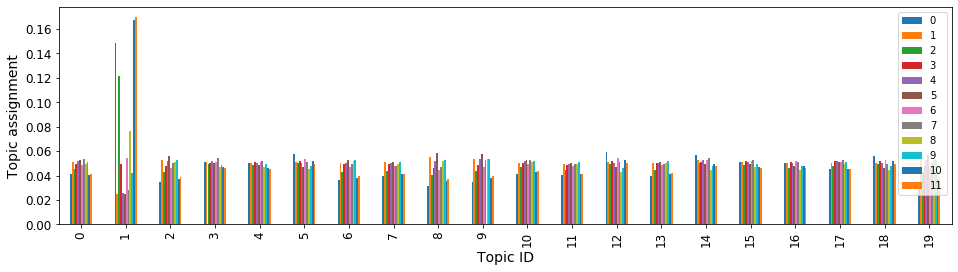

In [132]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

fs = 12
df=pd.DataFrame(predictions.T)
df.plot(kind='bar', figsize=(16,4), fontsize=fs)
plt.ylabel('Topic assignment', fontsize=fs+2)
plt.xlabel('Topic ID', fontsize=fs+2)

## Stop / Close the Endpoint

Finally, we should delete the endpoint before we close the notebook.

To restart the endpoint you can follow the code above using the same `endpoint_name` we created or you can navigate to the "Endpoints" tab in the SageMaker console, select the endpoint with the name stored in the variable `endpoint_name`, and select "Delete" from the "Actions" dropdown menu. 

In [133]:
sagemaker.Session().delete_endpoint(ntm_predictor.endpoint)

# Model Exploration

***Note: The following section is meant as a deeper dive into exploring the trained models. The demonstrated functionalities may not be fully supported or guaranteed. For example, the parameter names may change without notice.***


The trained model artifact is a compressed package of MXNet models from the two workers. To explore the model, we first need to install mxnet.

In [134]:
# If you use conda_mxnet_p36 kernel, mxnet is already installed, otherwise, uncomment the following line to install.
# !pip install mxnet 
import mxnet as mx

Here we download unpack the artifact

In [135]:
model_path = os.path.join(output_prefix, ntm._current_job_name, 'output/model.tar.gz')
model_path

'ntm/entertainment_news/output/ntm-2020-07-14-01-10-00-067/output/model.tar.gz'

In [136]:
boto3.resource('s3').Bucket(bucket).download_file(model_path, 'downloaded_model.tar.gz')

In [137]:
!tar -xzvf 'downloaded_model.tar.gz'

model_algo-2
model_algo-1


In [138]:
# use flag -o to overwrite previous unzipped content
!unzip -o model_algo-1

Archive:  model_algo-1
 extracting: meta.json               
 extracting: symbol.json             
 extracting: params                  


We can load the model parameters and extract the weight matrix $W$ in the decoder as follows

In [139]:
model = mx.ndarray.load('params')
W = model['arg:projection_weight']

Matrix $W$ corresponds to the $W$ in the NTM digram at the beginning of this notebook. Each column of $W$ corresponds to a learned topic. The elements in the columns of $W$ corresponds to the pseudo-probability of a word within a topic. We can visualize each topic as a word cloud with the size of each word be proportional to the pseudo-probability of the words appearing under each topic.

In [140]:
!pip install wordcloud
import wordcloud as wc

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_p36/bin/python -m pip install --upgrade pip' command.


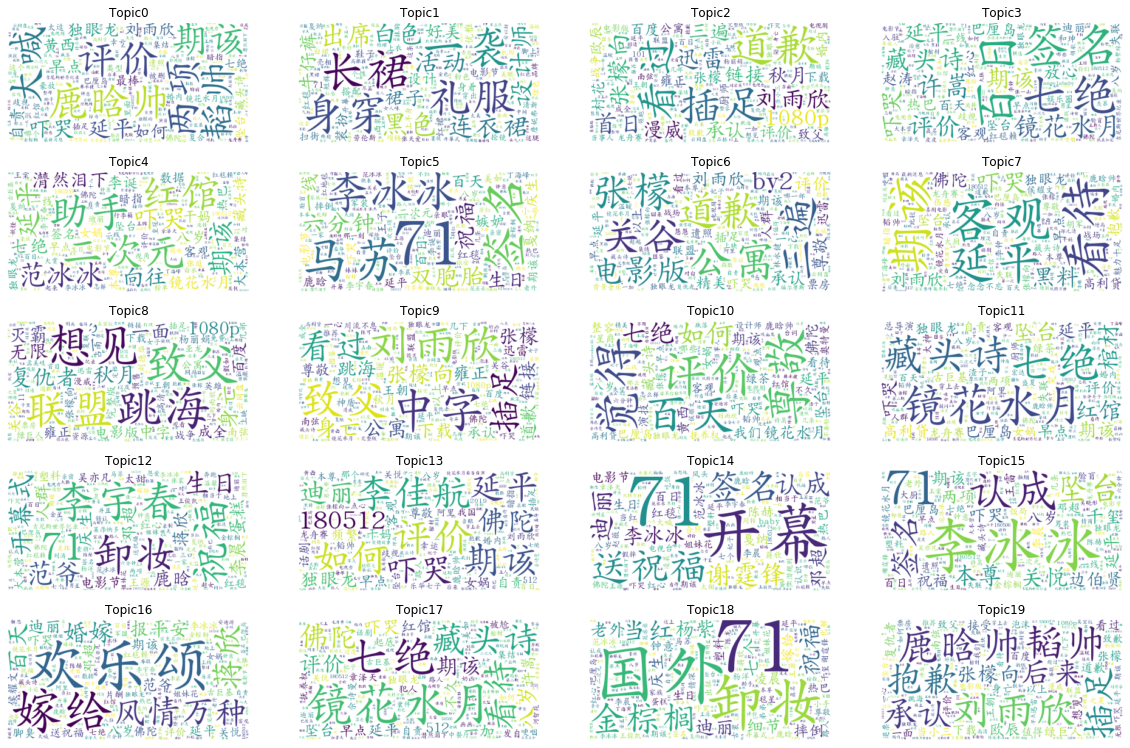

In [141]:
word_to_id = dict()
for i, v in enumerate(vocab_list):
    word_to_id[v] = i

limit = 24
n_col = 4
counter = 0
font_path = '/usr/share/fonts/cjkuni-ukai/ukai.ttc'
plt.figure(figsize=(20,16))
for ind in range(num_topics):

    if counter >= limit:
        break

    title_str = 'Topic{}'.format(ind)

    #pvals = mx.nd.softmax(W[:, ind]).asnumpy()
    pvals = mx.nd.softmax(mx.nd.array(W[:, ind])).asnumpy()

    word_freq = dict()
    for k in word_to_id.keys():
        i = word_to_id[k]
        word_freq[k] =pvals[i]

    wordcloud = wc.WordCloud(font_path=font_path, background_color='white').fit_words(word_freq)

    plt.subplot(limit // n_col, n_col, counter+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title_str)
    #plt.close()

    counter +=1